# Investigación en Compras de comestibles
## Objetivos
1. Desarrollar el EDA de las compras
2. Encontrar patrones en la compra de comestibles
    - Averiguar tendencias y estacionalidad en la compra de productos
    - Realizar análisis de canasta (o qué productos son comprados en conjunto)
3. Segmentación de los consumidores

### 1. Carga de paquetes necesarios

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

### 2. Carga de datos

In [3]:
df = pd.read_csv("input/Groceries_dataset.csv")
df.head(10)

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
5,4941,14-02-2015,rolls/buns
6,4501,08-05-2015,other vegetables
7,3803,23-12-2015,pot plants
8,2762,20-03-2015,whole milk
9,4119,12-02-2015,tropical fruit


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


### 3. Pre-procesamiento de datos

In [5]:
df.isnull().sum().sort_values(ascending=False)

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [6]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True) 
df['Member_number'] = pd.to_numeric(df['Member_number'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB


### 4. Realizar EDA

In [8]:
products_count = df.groupby(by=['itemDescription']).size().reset_index(name='frequency').sort_values(by='frequency',ascending=False)
products_count

,itemDescription,frequency
164,whole milk,2502
102,other vegetables,1898
122,rolls/buns,1716
138,soda,1514
165,yogurt,1334
...,...,...
124,rubbing alcohol,5
5,bags,4
4,baby cosmetics,3
114,preservation products,1


Tenemos que se venden 167 productos a lo largo de los 2 años del registro de datos. Grafiquemos los más vendidos y el porcentaje que representa cada uno del total de unidades vendidas:

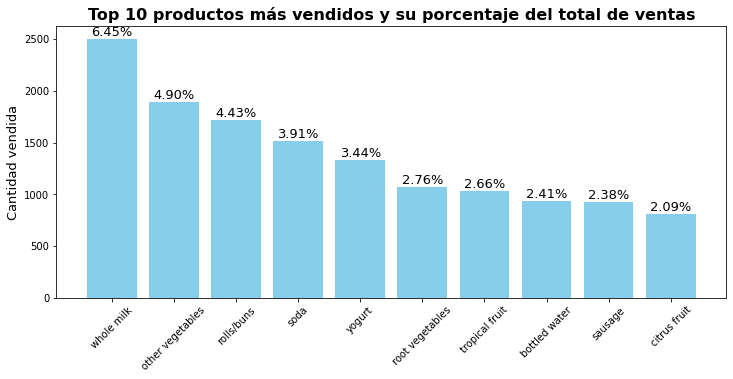

In [9]:
top_products = products_count.head(10)

values_tp = top_products['frequency']
labels_tp = top_products['itemDescription']
x_pos = np.arange(len(labels_tp))

plt.figure(figsize=(12,5))

bars = plt.bar(np.arange(len(values_tp)), values_tp, color = 'skyblue')

for bar in bars:
    height = bar.get_height()
    plt.annotate( "{0:.2f}%".format(height/387.65),(bar.get_x() + bar.get_width()/2, height+.05),ha="center",va="bottom",fontsize=13)

plt.ylabel('Cantidad vendida', fontsize=13)
 
plt.title('Top 10 productos más vendidos y su porcentaje del total de ventas', fontsize=16, fontweight='bold')

plt.xticks(x_pos, labels_tp, rotation=45)

plt.show()

In [10]:
products_month=df.set_index(['Date']) ## Setting date as index for plotting purpose
products_month = products_month.groupby(['Date']).count().reset_index()
products_month = products_month.resample('M', on='Date')['itemDescription'].sum()
products_month.head()

Date
2014-01-31    1527
2014-02-28    1437
2014-03-31    1411
2014-04-30    1561
2014-05-31    1615
Freq: M, Name: itemDescription, dtype: int64

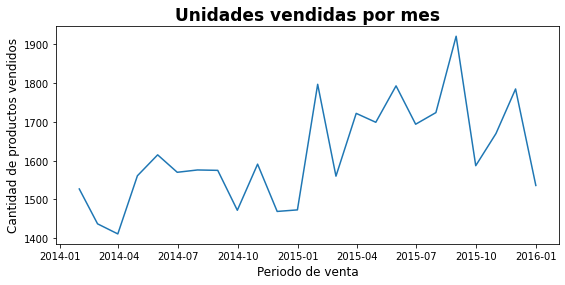

In [11]:
plt.figure(figsize=(9, 4))
plt.plot(products_month)

plt.title('Unidades vendidas por mes', fontsize=17, fontweight='bold')

plt.xlabel('Periodo de venta', fontsize=12)
plt.ylabel('Cantidad de productos vendidos', fontsize=12)
plt.show()

### 5. Averiguar tendencias y estacionalidad en la compra de productos

Ahora realizaremos un análisis que busca saber si existen tendencias y estacionalidad en la compra de los diversos productos comestibles. Definimos tendencias como trayectorias a largo plazo que toman las series de tiempo de compra de un producto, y estacionalidad como patrones recurrentes en una frecuencia fija (ej: mayor compra durante fines de año). Para ello, primero filtramos la base de datos para solo un producto, por ejemplo, Whole milk, el producto más vendido.

In [12]:
product_df = df[df['itemDescription'] == "whole milk"]
product_df

,Member_number,Date,itemDescription
1,2552,2015-01-05,whole milk
4,3037,2015-02-01,whole milk
8,2762,2015-03-20,whole milk
21,2867,2015-11-12,whole milk
53,1061,2015-09-05,whole milk
...,...,...,...
38667,3667,2014-05-11,whole milk
38672,4211,2014-04-03,whole milk
38688,2049,2014-04-02,whole milk
38689,4855,2014-06-16,whole milk


In [13]:
product_df = df[df['itemDescription'] == "whole milk"]
product_df = product_df.groupby(['Date'])['itemDescription'].count().reset_index(name='counts')
product_df

,Date,counts
0,2014-01-01,2
1,2014-01-02,4
2,2014-01-03,2
3,2014-01-05,5
4,2014-01-06,2
...,...,...
692,2015-12-26,2
693,2015-12-27,3
694,2015-12-28,4
695,2015-12-29,6


In [14]:
product_series = product_df.set_index(['Date'])
product_series = product_series['counts'].resample('D').mean()
product_series.fillna(0, inplace = True)
product_series.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 729 entries, 2014-01-01 to 2015-12-30
Freq: D
Series name: counts
Non-Null Count  Dtype  
--------------  -----  
729 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


Hubo 32 días en los que no se compró Whole Milk, por lo que estos se llenaron con ceros para completar la serie de tiempo. 

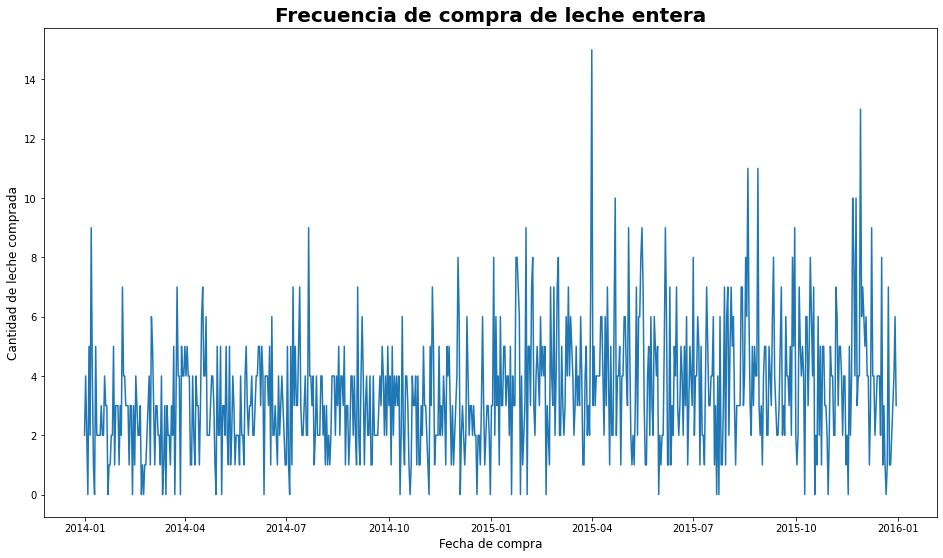

In [15]:
plt.figure(figsize=(16, 9))
plt.plot(product_series)

plt.title('Frecuencia de compra de leche entera', fontsize=20, fontweight='bold')

plt.xlabel('Fecha de compra', fontsize=12)
plt.ylabel('Cantidad de leche comprada', fontsize=12)
plt.show()

Ahora procederemos a averiguar si la Leche entera es estacionaria o no. Si tiene tendencias o estacionalidad, entonces no será una serie estacionaria, puesto que el valor esperado y/o la volatilidad de la serie dependerían del tiempo en vez de ser constantes. 

In [16]:
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
acf_values = acf(product_series)

In [18]:
np.round(acf_values, 2)

array([ 1.  ,  0.14,  0.09,  0.05,  0.08,  0.  ,  0.1 ,  0.03,  0.08,
        0.1 ,  0.1 ,  0.08,  0.08,  0.08,  0.11,  0.07,  0.02,  0.03,
        0.01,  0.1 ,  0.01,  0.09,  0.1 ,  0.14,  0.02,  0.07,  0.02,
       -0.01, -0.02])

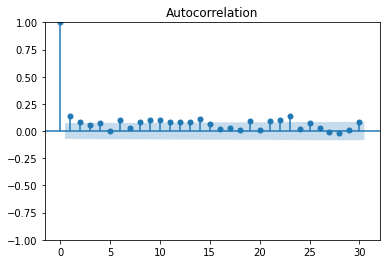

In [19]:
plot_acf(product_series, lags=30)
plt.show()

Se obtiene que el valor del ACF decae a 0 rápidamente, lo que nos sugiere que la serie es estacionaria, dado que para series no-estacionarias la decaída a 0 sería más pausada. Como segundo método de comprobación, realizamos el test de Dickey-Fuller aumentado. Si nuestro valor-p es mayor a 0.05, consideraremos que no se podría rechazar la hipótesis 0 de que la serie es no-estacionaria.  

In [20]:
print("Observations of Augmented Dickey-fuller test")
result = adfuller(product_series)
print('ADF Test Statistic: %f' % result[0])
print('5%% Critical Value: %f' % result[4]['5%'])
print(f'p-value: {result[1]}')

Observations of Augmented Dickey-fuller test
ADF Test Statistic: -4.504313
5% Critical Value: -2.865591
p-value: 0.00019314103343333214


Con ello obtenemos que, dado que el valor-p es muy menor a 0.05, se rechaza la hipótesis H0 del test y por tanto *la serie de tiempo es estacionaria.* Esto es importante porque significa que el promedio de la serie no es una función del tiempo, y **por tanto no tenemos efectos significativos de tendencias o temporadas/estaciones dentro de la compra del producto**.

Ahora bien, este análisis se ha realizado con el producto más vendido, la Leche entera. Ahora utilizaremos este mismo código para realizar una inspección definitiva de la estacionalidad, realizando el gráfico de función de autocorrelación (ACF) para los 10 productos más vendidos.

In [21]:
def time_series(product, df):
    product_df = df[df['itemDescription'] == product]
    product_df = product_df.groupby(['Date'])['itemDescription'].count().reset_index(name='counts')
    product_series = product_df.set_index(['Date'])
    product_series = product_series['counts'].resample('D').mean()
    product_series.fillna(0, inplace = True)
    return product_series

#### Procedemos entonces a saber cuáles de los 10 productos más vendidos tienen tendencias o estacionalidad.

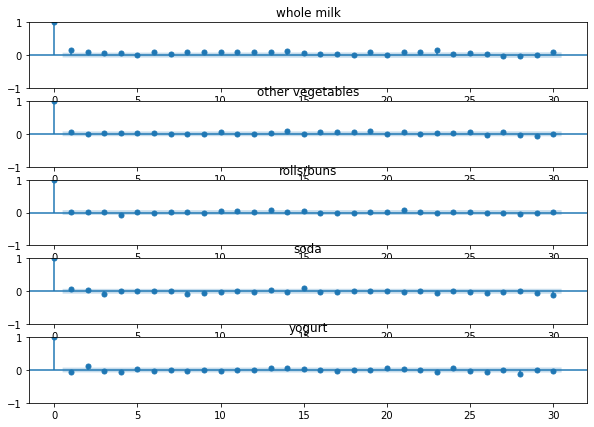

In [22]:
fig, (ax, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, figsize=(10,7)) # create two subplots, one in each row
ax_list = [ax, ax2, ax3, ax4, ax5]
for i in range(0, 5):
    item = top_products['itemDescription'].values[i]
    plot_acf(time_series(item, df), lags=30, ax=ax_list[i], title = item)
plt.show()

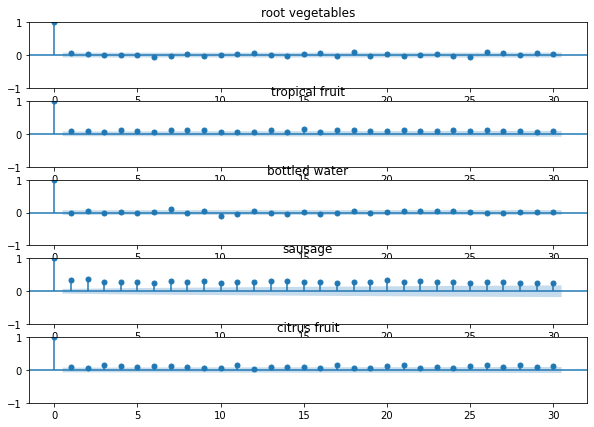

In [23]:
fig, (ax, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, figsize=(10,7)) # create two subplots, one in each row
ax_list = [ax, ax2, ax3, ax4, ax5]
for i in range(5, 10):
    item = top_products['itemDescription'].values[i]
    plot_acf(time_series(item, df), lags=30, ax=ax_list[i-5], title = item)
plt.show()

¡Eureka! **De los 10 productos más vendidos, solo las Sausages pueden tener una tendencia o estacionalidad significativa en su compra.** Realizaremos el Dickey-fuller test para asegurar que existe una tendencia en la compra de sausages.

In [24]:
analysis = time_series('sausage', df)
print("Observations of Augmented Dickey-fuller test")
result = adfuller(analysis)
print('ADF Test Statistic: %f' % result[0])
print('5%% Critical Value: %f' % result[4]['5%'])
print(f'p-value: {result[1]}')

Observations of Augmented Dickey-fuller test
ADF Test Statistic: -1.942108
5% Critical Value: -2.865625
p-value: 0.31251871626017214


Dado que el valor-p es mayor a 0.05, no podemos rechazar la hipótesis de que la serie sea no-estacionaria. Por tanto, puede que exista una tendencia o estacionalidad. Descompongamos la serie de tiempo para comprobarlo:

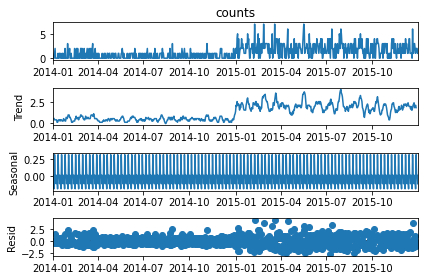

In [25]:
decompose_result_mult = seasonal_decompose(analysis, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

Podemos observar que la estacionalid no tiene un patrón definido, pero podemos observar que las Sausages tienen una tendencia efectivamente, como se observa en su gráfico respectivo.

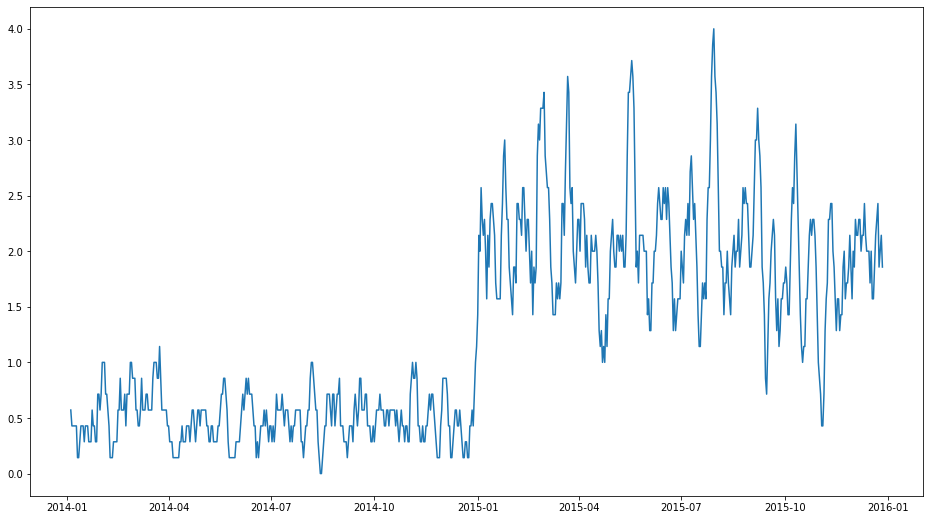

In [26]:
plt.figure(figsize=(16, 9))
plt.plot(trend)

De este análisis concluimos que, en general, los productos comestibles del comercio del que provienen los datos no siguen ninguna tendencia o estacionalidad en su compra/venta. Sin embargo, se detectó una tendencia de aumento en la compra de Sausages a partir de inicios del 2015, por lo que se puede recomendar analizar las expectativas de venta de este producto para el año siguiente.

### 6. Market Basket Analysis (o qué productos suelen ser comprados en conjunto)

Para el análisis de canasta se utilizarán reglas de asociación. En concreto, usaremos el algoritmo apriori de la minería de datos para encontrar de forma eficiente los conjuntos de ítems frecuentes comprados. Para ello, primero debemos ordenar nuestra base de datos para obtener qué items son comprados en conjunto. Para ello asumiremos que una persona solo realiza una compra en un mismo día: es decir, los items comprados el mismo día por la misma persona se asumirán como parte de una misma compra.

In [27]:
# Sort the data by member and the date of the purchase of the item
df_sorted = df.sort_values(by = ['Member_number', 'Date'], ascending = True) 
df_sorted

,Member_number,Date,itemDescription
13331,1000,2014-06-24,whole milk
29480,1000,2014-06-24,pastry
32851,1000,2014-06-24,salty snack
4843,1000,2015-03-15,sausage
8395,1000,2015-03-15,whole milk
...,...,...,...
9340,5000,2014-11-16,bottled beer
25489,5000,2014-11-16,other vegetables
3578,5000,2015-02-10,soda
19727,5000,2015-02-10,root vegetables


In [28]:
# Creating list of items purchased at the same time by the same person
df_grouped = df.groupby(['Member_number', 'Date'], 
                  as_index=False)['itemDescription'].agg(lambda x: list(x))
df_grouped = df_grouped['itemDescription']
df_grouped

0                        [whole milk, pastry, salty snack]
1        [sausage, whole milk, semi-finished bread, yog...
2                               [soda, pickled vegetables]
3                           [canned beer, misc. beverages]
4                              [sausage, hygiene articles]
                               ...                        
14958                    [butter milk, whipped/sour cream]
14959                               [bottled water, herbs]
14960                      [fruit/vegetable juice, onions]
14961                     [bottled beer, other vegetables]
14962         [soda, root vegetables, semi-finished bread]
Name: itemDescription, Length: 14963, dtype: object

Ahora obtuvimos una lista de los items que componen cada compra realizada, que es lo que necesita el algoritmo Apriori como input. **Ahora utilizaremos R para la continuación del análisis**, debido a que la librería Arulesviz es más potente para la realización de gráficos del algoritmo apriori.

In [40]:
import csv
%load_ext rpy2.ipython

with open("item_list.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(df_grouped)

In [30]:
%%R -i df -w 5 -h 5 --units in -r 100
library(plyr)
library(arules)
library(arulesViz)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: 'arules'


R[write to console]: The following objects are masked from 'package:base':

    abbreviate, write




Se procede a leer el CSV que creamos y se remueven los símbolos y espacios en blanco que hay entre la descripción de los productos. Ahora con apriori obtenemos un resumen de las 100 reglas creadas.

In [31]:
%%R -i df -w 5 -h 5 --units in -r 100
item_list = read.transactions(file="item_list.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1)
item_list@itemInfo$labels <- gsub("\"","",item_list@itemInfo$labels)
rules <- apriori(item_list, parameter = list(minlen = 2, support = 0.001, confidence = 0.05, target="rules"))
summary(rules)

distribution of transactions with duplicates:
items
  1   2   3   4 
270  19   1   1 
Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.05    0.1    1 none FALSE            TRUE       5   0.001      2
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 14 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[165 item(s), 14963 transaction(s)] done [0.01s].
sorting and recoding items ... [139 item(s)] done [0.00s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [100 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
set of 100 rules

rule length distribution (lhs + rhs):sizes
  2 
100 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      2       2       2       2       2       2 

summary of quality measures:


In [32]:
%%R -i df -w 5 -h 5 --units in -r 100
subrules <- sort (rules, by="lift", decreasing=TRUE) # Ordering rules by lift
inspect(subrules[1:10])

     lhs              rhs                support     confidence coverage   
[1]  {frankfurter} => {other vegetables} 0.001403462 0.2307692  0.006081668
[2]  {sausage}     => {yogurt}           0.002071777 0.1823529  0.011361358
[3]  {sausage}     => {whole milk}       0.002405935 0.2117647  0.011361358
[4]  {sausage}     => {other vegetables} 0.001804451 0.1588235  0.011361358
[5]  {frankfurter} => {whole milk}       0.001136136 0.1868132  0.006081668
[6]  {sausage}     => {rolls/buns}       0.001670788 0.1470588  0.011361358
[7]  {sausage}     => {soda}             0.001470293 0.1294118  0.011361358
[8]  {beef}        => {whole milk}       0.001470293 0.1506849  0.009757402
[9]  {chicken}     => {whole milk}       0.001002473 0.1500000  0.006683152
[10] {pork}        => {soda}             0.001069304 0.1052632  0.010158391
     lift     count
[1]  3.339458 21   
[2]  3.011641 31   
[3]  2.335030 36   
[4]  2.298333 27   
[5]  2.059901 17   
[6]  2.052650 25   
[7]  2.010787 22   
[8] 

Obtenemos que las 7 primeras reglas de asociación tienen bajo support y confianza, probablemente por la falta de frecuencia en los datos, pero un Lift entre 2 y 3, por lo que **aquellos que compren frankfurter seguramente comprarán otros vegetales**. De la misma forma, aquellos que compren Sausages seguramente comprarán yogurt.

R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



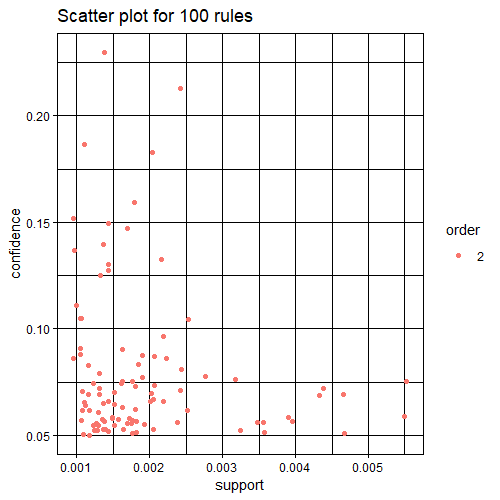

In [33]:
%%R -i df -w 5 -h 5 --units in -r 100
plot(rules, method = "two-key plot")

En el gráfico anterior obtenemos que la mayoría de asociaciones son de orden 2, es decir, los conjuntos de ítemes comprados juntos se ha limitado a parejas, dado que conjuntos mayores no cumplían nuestro criterio de confianza. En los gráficos siguientes, podemos visualizar el lift y confianza de las reglas generadas por el algoritmo.

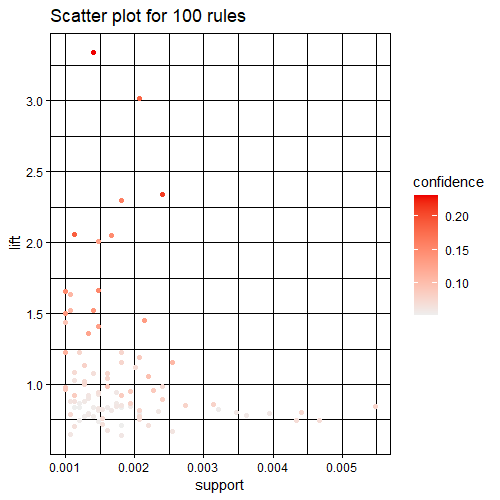

In [34]:
%%R -i df -w 5 -h 5 --units in -r 100
plot(rules, measure = c("support", "lift"), shading = "confidence", jitter = 0)

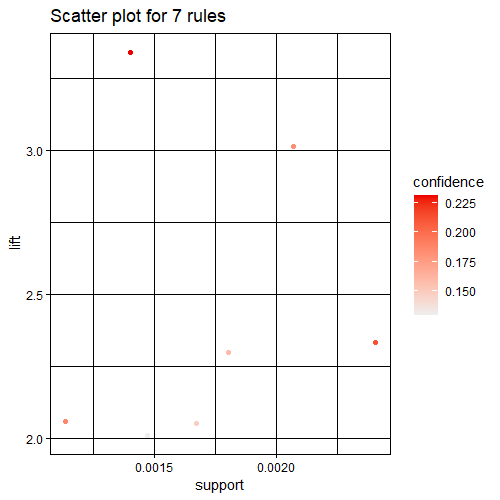

In [35]:
%%R -i df -w 5 -h 5 --units in -r 100
subrules <- subset(rules, lift>2)
plot(subrules, measure = c("support", "lift"), shading = "confidence", jitter = 0)

De los dos gráficos anteriores obtenemos que, efectivamente, los 7 conjuntos de ítemes con Lift > 2 presentan además una mayor confianza, por lo que **estos serán nuestros principales insights sobre compras frecuentes**. Realizaremos un grafo para ver la relación entre estos ítems:

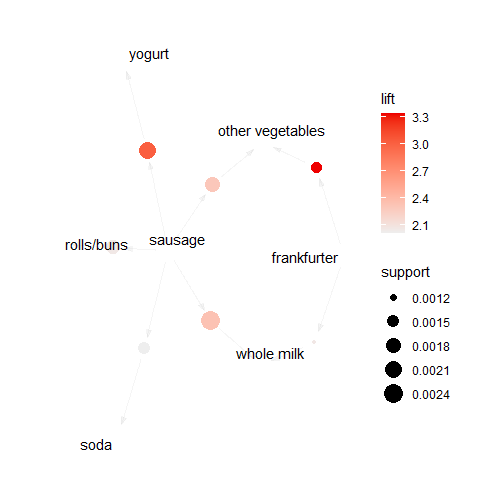

In [36]:
%%R -i df -w 5 -h 5 --units in -r 100
subrules2 <- subset(rules, lift>2)
plot(subrules2, method = "graph")

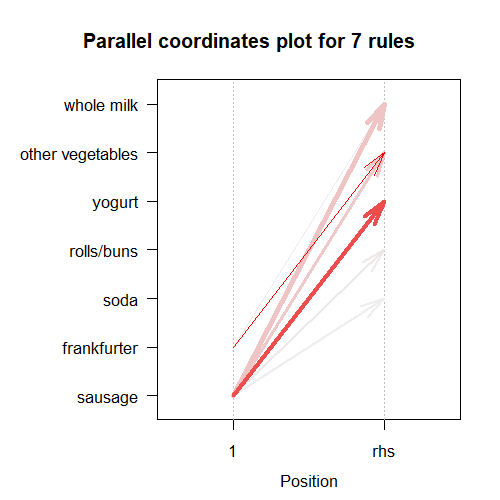

In [37]:
%%R -i df -w 5 -h 5 --units in -r 100
plot(subrules2, method="paracoord")

Tanto del análisis de los top 7 conjuntos frecuentes más confiables, como del análisis del resto de reglas descrito más adelante, obtenemos algunos insights como: 
- Comprar Sausages suele inducir la compra de otros productos: podrían realizarse packs o descuentos en este producto.
- Whole Milk y otros vegetales también son productos que se compran como complemento a otros, además de ser del top 10 más vendidos.
- Se recomienda dedicar espacio adicional en las estanterías de estos productos, y reducir el espacio de aquellos menos comprados.
- Se pueden utilizar las 7 reglas de más confianza para mantener estos productos cerca unos de otros en el local de comercio.

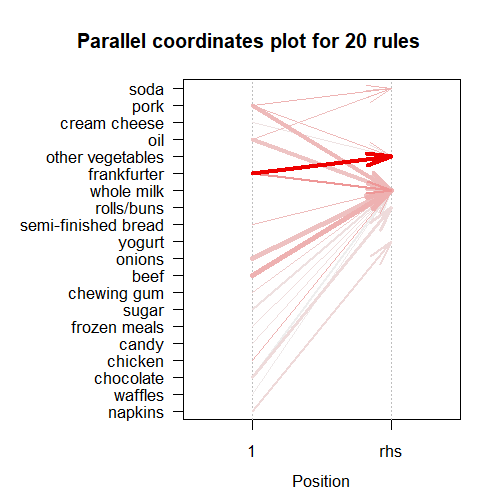

In [38]:
%%R -i df -w 5 -h 5 --units in -r 100
plot(rules[1:20], method="paracoord")

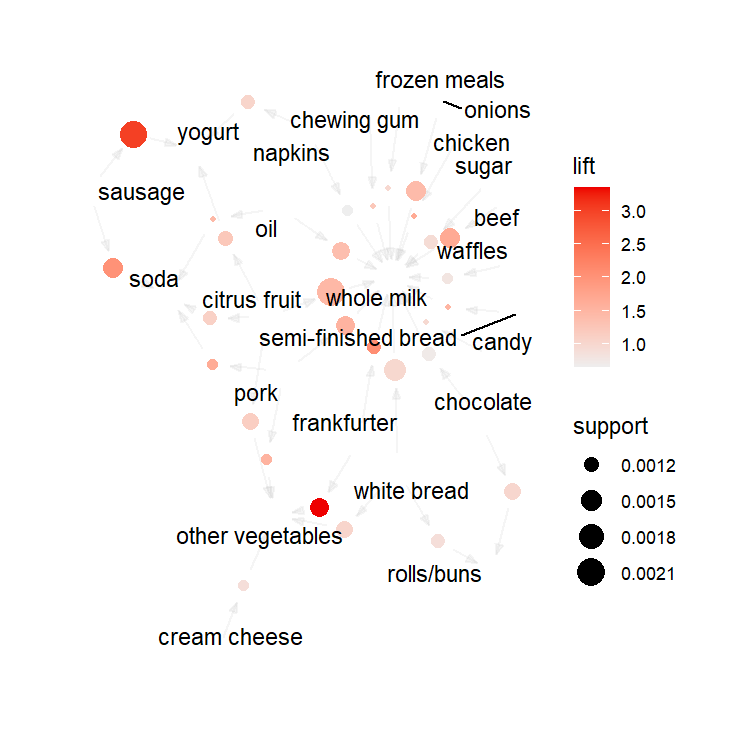

In [39]:
%%R -i df -w 5 -h 5 --units in -r 150
plot(rules[1:30], method="graph")